In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"combi2k2","key":"a7571c9c172a0c5f9460a4129337f6c3"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d combi2k2/chess-pieces-detection

 55% 9.00M/16.3M [00:00<00:00, 16.6MB/s]
100% 16.3M/16.3M [00:00<00:00, 27.7MB/s]


In [ ]:
! unzip chess-pieces-detection.zip

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import cv2
from PIL import Image

## Setting up device:

In [7]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla K80


## Generating anchor boxes:

In [8]:
fe_size = 400 // 8

ctr_x = np.arange(8, (fe_size + 1) * 8, 8)
ctr_y = np.arange(8, (fe_size + 1) * 8, 8)

In [9]:
# coordinates of the 2500 center points to generate anchor boxes
ctr = np.zeros((fe_size ** 2, 2))

for i in range(len(ctr_x) * len(ctr_y)):
    x = i // len(ctr_y)
    y = i %  len(ctr_y)

    ctr[i, 0] = ctr_x[x] - 4
    ctr[i, 1] = ctr_y[y] - 4

print(ctr.shape)

(2500, 2)


In [10]:
# for each of the 2500 anchors, generate 12 anchor boxes
# 2500 * 9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [4, 8, 16, 32]

sub_sample = 8
anchor_boxes = np.zeros(((fe_size * fe_size * 12), 4))
index = 0

for c in ctr:
    ctr_x = c[0]
    ctr_y = c[1]

    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])

            anchor_boxes[index, 0] = ctr_x - h / 2.
            anchor_boxes[index, 1] = ctr_y - w / 2.
            anchor_boxes[index, 2] = ctr_x + h / 2.
            anchor_boxes[index, 3] = ctr_y + w / 2.
            index += 1

print(anchor_boxes.shape)

(30000, 4)


## Loading backbone model (VGG16):

In [11]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained = True).to(device)
layer = list(model.features)

for i, fe in enumerate(layer):
    print(f'Feature {i + 1}: {fe}')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Feature 1: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 2: ReLU(inplace=True)
Feature 3: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 4: ReLU(inplace=True)
Feature 5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Feature 6: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 7: ReLU(inplace=True)
Feature 8: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 9: ReLU(inplace=True)
Feature 10: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Feature 11: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 12: ReLU(inplace=True)
Feature 13: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 14: ReLU(inplace=True)
Feature 15: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 16: ReLU(inplace=True)
Feature 17: MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [12]:
# extract the feature maps of size 50 x 50 (apply MaxPool2d 3 times)
layer = layer[: 23]

# Convert this list into a Sequential module
fe_extractor = nn.Sequential(*layer).to(device)

## Show an example of input:





In [13]:
MyTransform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([400, 400])
]) # Defing PyTorch Transform

def Image_Prep(img):
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    return  MyTransform(img)

In [14]:
def calc_iou(boxA, boxB):
    xA1, yA1, xA2, yA2 = boxA
    xB1, yB1, xB2, yB2 = boxB

    area_A = (xA2 - xA1) * (yA2 - yA1)
    area_B = (xB2 - xB1) * (yB2 - yB1)

    inner_x1 = max(xA1, xB1);   inner_x2 = min(xA2, xB2)
    inner_y1 = max(yA1, yB1);   inner_y2 = min(yA2, yB2)

    if (inner_x1 >= inner_x2):  return  0
    if (inner_y1 >= inner_y2):  return  0

    inner_area = (inner_y2 - inner_y1) * (inner_x2 - inner_x1)

    return  1.0 * inner_area / (area_A + area_B - inner_area)

## Rebalance the label:
Sometimes, there are too many negative labels, so the trained model will be biased. So there are 2 solutions to handle this problem:

- $\textbf{Solution 1}$: Ignore certain number of label (get rid of data)
- $\textbf{Solution 2}$: Make positive labels contribute more to the final loss function.

I did not have enough skills so I choose the 1st approach

In [15]:
def label_balancing(label, num_classes = 2):
    pos_index = np.where(label == 1)[0]
    neg_index = np.where(label == 0)[0]

    n_pos = 0.5 * label.shape[0]
    n_neg = np.sum(label == 1)

    if len(pos_index) > n_pos:  label[np.random.choice(pos_index, size = (len(pos_index) - n_pos), replace = False)] = -1
    if len(neg_index) > n_neg:  label[np.random.choice(neg_index, size = (len(neg_index) - n_neg), replace = False)] = -1

## Calculate the groundtruth locs of proposed regions:

In [16]:
def calc_gt_locs(regions, gt_bbox):
    height = regions[:, 2] - regions[:, 0]
    width  = regions[:, 3] - regions[:, 1]
    ctr_x  = regions[:, 0] + 0.5 * height
    ctr_y  = regions[:, 1] + 0.5 * width

    # groundtruth box which correspond this valid anchor box h, w, cx, cy 
    base_height = gt_bbox[:, 2] - gt_bbox[:, 0]
    base_width  = gt_bbox[:, 3] - gt_bbox[:, 1]
    base_ctr_x  = gt_bbox[:, 0] + 0.5 * base_height
    base_ctr_y  = gt_bbox[:, 1] + 0.5 * base_width

    # valid anchor boxes loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps) #make height != 0 by let its minimum value be eps
    width  = np.maximum(width,  eps)

    dx = (base_ctr_x - ctr_x) / width
    dy = (base_ctr_y - ctr_y) / height

    dh = np.log(base_height / height)
    dw = np.log(base_width  / width)

    return  np.vstack((dx, dy, dh, dw)).transpose()

In [17]:
def Annotations_Prep(regions, bbox, RPN_training = True):
    index_inside = np.where(
        (regions[:, 0] >= 0) &
        (regions[:, 1] >= 0) &
        (regions[:, 2] < 400) &
        (regions[:, 3] < 400)
    )[0]
    valid_regions = regions[index_inside]

    bbox = np.array(bbox)
    ious = np.zeros((valid_regions.shape[0], bbox.shape[0]))
    
    for index in range(valid_regions.shape[0] * bbox.shape[0]):
        i = index // bbox.shape[0]
        j = index  % bbox.shape[0]

        ious[i, j] = calc_iou(valid_regions[i], bbox[j])

    gt_assignment = ious.argmax(axis = 1)
    max_iou = ious.max(axis = 1)

    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)

    # assign if the proposed region has a chesspiece or not
    if (RPN_training):
        label[gt_assignment] = 1
        label[max_iou >= 0.7] = 1
        label[max_iou <  0.3] = 0
    
    else: #Training ROI
        label[max_iou >= 0.8] = 1
        label[max_iou <  0.8] = 0

    # Rebalance the assigned labels
    label_balancing(label)

    # For each valid anchor box, find the groundtruth object which has max_iou
    max_iou_bbox = bbox[gt_assignment]

    #calculate the locs of each anchor box (not just valid anchor boxes)
    gt_locs_valid_regions = calc_gt_locs(valid_regions, max_iou_bbox)

    gt_labels = np.empty((len(anchor_boxes),), dtype = label.dtype)
    gt_labels.fill(-1)
    gt_labels[index_inside] = label

    gt_locs = np.zeros(anchor_boxes.shape, dtype = gt_locs_valid_regions.dtype)
    gt_locs[index_inside, :] = gt_locs_valid_regions

    return  gt_locs, gt_labels

In [18]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Create my own custom dataset:

In [19]:
def Load_Annotations(base_path):
    with open(f'{base_path}/_annotations.coco.json', 'r') as f:
        data = json.load(f)
    
    images = data["images"]
    bboxes = data["annotations"]
    
    pic_names = ["" for i in range(len(images))]
    pic_boxes = [[] for i in range(len(images))]
    
    H_ratio = 400/416.
    W_ratio = 400/416.
    
    for img in images:  pic_names[img["id"]] = img["file_name"]
    for box in bboxes:
        pic_name = box["image_id"]
        box_locs = box["bbox"]
        
        x1, y1, h, w = box_locs
        x2 = x1 + h
        y2 = y1 + w
        
        x1 = x1 * H_ratio;  y1 = y1 * W_ratio
        x2 = x2 * H_ratio;  y2 = y2 * W_ratio
        
        pic_boxes[pic_name].append((x1, y1, x2, y2))

    return  [cv2.imread(f'{base_path}/{name}') for name in pic_names], pic_boxes

## Create custom Dataset to train RPN:

In [20]:
class RPN_dataset(Dataset):
    def __init__(self, base_path):
        super().__init__()

        images, bboxes = Load_Annotations(base_path)
            
        self.images = images
        self.target = [Annotations_Prep(anchor_boxes, gt_box) for gt_box in bboxes]

        self.n_samples = len(images)
    
    def __getitem__(self, index):
        image  = self.images[index]
        target = self.target[index]

        return  Image_Prep(image), target
    
    def __len__(self):
        return  self.n_samples

In [21]:
train_rpn_ds = RPN_dataset('/content/train')
valid_rpn_ds = RPN_dataset('/content/valid')

### Setting up hyper parameters:

In [22]:
num_epochs = 20
batch_size = 16
learning_rate = 0.005

In [23]:
train_rpn_dl = DataLoader(train_rpn_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_rpn_dl = DataLoader(valid_rpn_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

In [24]:
n_anchor = 12 # number of anchor boxes having the center being the current point

class RPN_layer(nn.Module):
    def __init__(self):
        super().__init__()
        inp_channels = 512
        mid_channels = 512
        
        self.conv1 = nn.Conv2d(inp_channels, mid_channels, 3, 1, 1)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()

        self.reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()

        self.cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0) ## I will use softmax here. you can equally use sigmoid if u replace 2 with 1.
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
    
    def forward(self, x):
        x = self.conv1(x)
        
        pred_anchor_locs  = self.reg_layer(x)
        pred_anchor_label = self.cls_layer(x)
        
        return  pred_anchor_locs, pred_anchor_label

### Initialize my Model:

In [25]:
RPN_model = RPN_layer().to(device)
optimizer = torch.optim.SGD(RPN_model.parameters(), lr = learning_rate)

In [26]:
epochs_RPN = []
losses_RPN = []

## Start Training Loop:

In [27]:
for epoch in range(num_epochs):
    batch_index = 1
    Epoch_LOSS = 0
    
    for images, target in train_rpn_dl:
        images = images.to(device)
        outmap = fe_extractor(images)

        anchor_locs  = target[0].to(device).contiguous().view(-1, 4)
        anchor_label = target[1].to(device).contiguous().view(-1)
        
        #forward step
        pred_locs, pred_score = RPN_model(outmap)

        pred_locs  = pred_locs.permute(0, 2, 3, 1).contiguous().view(-1, 4)
        pred_score = pred_score.permute(0, 2, 3, 1).contiguous().view(-1, 2)

        pos  = anchor_label > 0
        mask = pos.unsqueeze(1).expand_as(pred_locs)

        pred_locs   = pred_locs[mask]
        anchor_locs = anchor_locs[mask]

        rpn_cls_loss = F.cross_entropy(pred_score, anchor_label.long(), ignore_index = -1)
        rpn_reg_loss = F.smooth_l1_loss(pred_locs, anchor_locs)

        rpn_total_loss = rpn_cls_loss + 5. * rpn_reg_loss
        Epoch_LOSS += rpn_total_loss
        
        optimizer.zero_grad(); rpn_total_loss.backward()
        optimizer.step()

        if (batch_index % 10 == 0):
            print(f'Epoch {epoch + 1}/{num_epochs}, batch {batch_index}: train_loss = {rpn_total_loss}')
        
        batch_index += 1
    
    epochs_RPN.append(len(epochs_RPN))
    losses_RPN.append(Epoch_LOSS)

Epoch 1/20, batch 10: train_loss = 0.5846555958974756
Epoch 1/20, batch 20: train_loss = 0.5072805395774993
Epoch 1/20, batch 30: train_loss = 0.5250165651580486
Epoch 2/20, batch 10: train_loss = 0.4824673973890842
Epoch 2/20, batch 20: train_loss = 0.4079347545376104
Epoch 2/20, batch 30: train_loss = 0.4304458145893912
Epoch 3/20, batch 10: train_loss = 0.38159842280833833
Epoch 3/20, batch 20: train_loss = 0.35413873293960163
Epoch 3/20, batch 30: train_loss = 0.40985437395324
Epoch 4/20, batch 10: train_loss = 0.35660113423903184
Epoch 4/20, batch 20: train_loss = 0.33677706697288246
Epoch 4/20, batch 30: train_loss = 0.3426335176765377
Epoch 5/20, batch 10: train_loss = 0.37645462806736385
Epoch 5/20, batch 20: train_loss = 0.36308529346213503
Epoch 5/20, batch 30: train_loss = 0.33525067919908685
Epoch 6/20, batch 10: train_loss = 0.321882985844949
Epoch 6/20, batch 20: train_loss = 0.30263257488167317
Epoch 6/20, batch 30: train_loss = 0.29357633470071764
Epoch 7/20, batch 10: 

tensor(9.0597, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


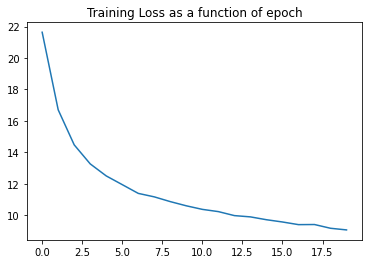

In [28]:
plt.plot(epochs_RPN, losses_RPN)
plt.title("Training Loss as a function of epoch")

print(losses_RPN[-1])

In [29]:
torch.save(RPN_model.state_dict(), 'My_RPN.model')

In [30]:
RPN_model = RPN_layer().to(device)
RPN_model.load_state_dict(torch.load('My_RPN.model', map_location = torch.device(device)))

<All keys matched successfully>

In [31]:
def Proposed_Regions(base_boxes, pred_anchor_locs_numpy):
    base_height = base_boxes[:, 2] - base_boxes[:, 0]
    base_width  = base_boxes[:, 3] - base_boxes[:, 1]

    base_ctr_x = base_boxes[:, 0] + 0.5 * base_height
    base_ctr_y = base_boxes[:, 1] + 0.5 * base_width

    # The 30000 anchor boxes location and labels predicted by RPN (convert to numpy)
    # format = (dy, dx, dh, dw)
    dx = pred_anchor_locs_numpy[:, 0::4] # dx
    dy = pred_anchor_locs_numpy[:, 1::4] # dy
    dh = pred_anchor_locs_numpy[:, 2::4] # dh
    dw = pred_anchor_locs_numpy[:, 3::4] # dw
    
    # ctr_x = dx predicted by RPN * anchor_h + anchor_cx
    # ctr_y similar
    # h = exp(dh predicted by RPN) * anchor_h
    # w similar
    ctr_x = dx * base_height[:, np.newaxis] + base_ctr_x[:, np.newaxis]
    ctr_y = dy * base_width[:, np.newaxis]  + base_ctr_y[:, np.newaxis]
    
    h = np.exp(dh) * base_height[:, np.newaxis]
    w = np.exp(dw) * base_width[:, np.newaxis]

    # the final locations of the predicted bounding boxes have the form (x1, y1, x2, y2)
    roi = np.zeros(pred_anchor_locs_numpy.shape, dtype = pred_anchor_locs_numpy.dtype)
    roi[:, 0::4] = ctr_x - 0.5 * h
    roi[:, 1::4] = ctr_y - 0.5 * w
    roi[:, 2::4] = ctr_x + 0.5 * h
    roi[:, 3::4] = ctr_y + 0.5 * w

    # trim the boxes which cover the area outside of the image
    roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, 400)
    roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, 400)

    return  roi

## Use Non-Maxima Suppression:

- Send $30000$ RoIs prdicted by RPN to Fast RCNN to predict bbox + classifications
- Reduce $30000$ RoIs to $2000$

In [32]:
nms_thresh = 0.7  # non-maximum supression (NMS)
min_size   = 8

In [33]:
def NMS_filter(base_boxes, pred_locs, pred_score):
    pred_locs  = pred_locs.contiguous().view(-1, 4)
    pred_score = pred_score.contiguous().view(-1, 2)

    pred_anchor_locs_numpy  = pred_locs.cpu().data.numpy()
    pred_anchor_score_numpy = pred_score.cpu().data.numpy()[:, 1]

    roi = Proposed_Regions(base_boxes, pred_anchor_locs_numpy)

    # elimiate proposed boxes which are too small
    hs = roi[:, 2] - roi[:, 0]
    ws = roi[:, 3] - roi[:, 1]

    keep = np.where((hs >= min_size) & 
                    (ws >= min_size))[0]
    
    roi = roi[keep]

    # start NMS filter
    score = pred_anchor_score_numpy[keep]
    order = score.ravel().argsort()[::-1]
    order = order[:1000]

    roi = roi[order, :]

    # Take all the roi boxes [roi_array]
    x1 = roi[:, 0]; y1 = roi[:, 1]
    x2 = roi[:, 2]; y2 = roi[:, 3]

    # Find the areas of all the boxes [roi_area]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    #Take the indexes of order the probability score in descending order 
    order = order.argsort()[::-1]
    keep = []

    while (order.size > 0):
        i = order[0] #take the 1st elt in order and append to keep 
        keep.append(i)

        inner_x1 = np.maximum(x1[i], x1[order[1:]])
        inner_y1 = np.maximum(y1[i], y1[order[1:]])
        inner_x2 = np.minimum(x2[i], x2[order[1:]])
        inner_y2 = np.minimum(y2[i], y2[order[1:]])

        inner_h = np.maximum(0.0, inner_x2 - inner_x1 + 1)
        inner_w = np.maximum(0.0, inner_y2 - inner_y1 + 1)

        inter = inner_h * inner_w
        outer = areas[i] + areas[order[1:]] - inter

        ious = inter / outer
        inds = np.where(ious < nms_thresh)[0]

        order = order[inds + 1]
    
    return  roi[keep]# the final region proposals

### Testing RPN model

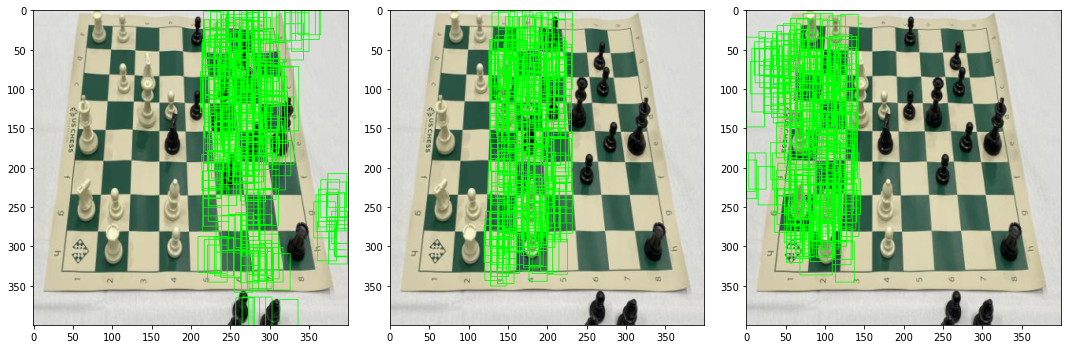

In [34]:
with torch.no_grad():
    img = cv2.imread('/content/test/a3863d0be6002c21b20ac88817b2c56f_jpg.rf.0413d5178136ace55f588df9556c060a.jpg')

    # calculate predicted label and locs
    img_clone = Image_Prep(img)
    img_clone = img_clone.unsqueeze(0).to(device)

    outmap = fe_extractor(img_clone)
    pred_locs, pred_score = RPN_model(outmap)
    
    pred_locs = pred_locs.permute(0, 2, 3, 1)
    pred_score = pred_score.permute(0, 2, 3, 1)

    rois = NMS_filter(anchor_boxes, pred_locs, pred_score)

    # show the bounding box of predicted boxes:
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, dsize = (400, 400), interpolation = cv2.INTER_AREA)


    #show the most potential regions
    fig, ax = plt.subplots(1, 3, figsize=(15,15))
    fig.tight_layout()

    img_clone = img.copy()

    for i in range(rois.shape[0] // 3):
        x1, y1, x2, y2 = rois[i]
        cv2.rectangle(img_clone, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    ax[0].imshow(img_clone)

    #show the regions which are less likely to contain chesspieces
    img_clone = img.copy()

    for i in range(rois.shape[0] // 3, 2 * rois.shape[0] // 3):
        x1, y1, x2, y2 = rois[i]
        cv2.rectangle(img_clone, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    ax[1].imshow(img_clone)

    #show the least potential regions
    img_clone = img.copy()

    for i in range(2 * rois.shape[0] // 3, rois.shape[0]):
        x1, y1, x2, y2 = rois[i]
        cv2.rectangle(img_clone, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    ax[2].imshow(img_clone)
    
plt.show()

## Create custom Dataset to train ROI:

In [35]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(*size)

In [36]:
class ROI_Dataset(Dataset):
    def __init__(self, base_path):
        super().__init__()

        images, bboxes = Load_Annotations(base_path)

        self.outmap = []
        self.target = []

        for img, bbox in zip(images, bboxes):
            img = Image_Prep(img)
            img = img.unsqueeze(0).to(device)

            outmap = fe_extractor(img)
            
            #finding region of interested predicted by RPN model
            pred_locs, pred_score = RPN_model(outmap)

            #filter out the ROIs by NMS
            pred_locs = pred_locs.permute(0, 2, 3, 1)
            pred_score = pred_score.permute(0, 2, 3, 1)

            rois = NMS_filter(anchor_boxes, pred_locs, pred_score)

            #preparing feature maps and their annotations
            outmap = outmap.cpu().data

            gt_locs, gt_label = Annotations_Prep(rois, bbox, RPN_training = False)
            keep_index = np.where(gt_label >= 0)[0]

            gt_locs  = gt_locs[keep_index]
            gt_label = gt_label[keep_index]

            rois = torch.from_numpy(rois[keep_index]).float()
            rois = rois / 8.0 #Downsampling ratio
            rois = rois.long()

            #choosing random samples
            index = np.arange(rois.shape[0])
            index = np.random.choice(index, size = min(30, rois.shape[0]), replace = False)

            rois = rois[index]
            gt_locs  = gt_locs[index]
            gt_label = gt_label[index]

            for i in range(rois.shape[0]):
                x1, y1, x2, y2 = rois[i]
                mask = outmap[0][..., x1: x2 + 1, y1: y2 + 1]
                temp = adaptive_max_pool(mask)[0]

                self.outmap.append(temp)
                self.target.append((gt_locs[i], gt_label[i]))
              
            if (len(self.outmap) > 5000):
                break

        self.n_samples = len(self.outmap)

    def __getitem__(self, index):
        return  self.outmap[index], self.target[index]

    def __len__(self):
        return  self.n_samples

In [37]:
print(torch.cuda.memory_summary(device=device, abbreviated=False)) 

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  635407 KB |    5405 MB |   21432 GB |   21431 GB |
|       from large pool |  631743 KB |    5402 MB |   21430 GB |   21429 GB |
|       from small pool |    3664 KB |       4 MB |       1 GB |       1 GB |
|---------------------------------------------------------------------------|
| Active memory         |  635407 KB |    5405 MB |   21432 GB |   21431 GB |
|       from large pool |  631743 KB |    5402 MB |   21430 GB |

In [38]:
train_roi_ds = ROI_Dataset('/content/train')
valid_roi_ds = ROI_Dataset('/content/valid')

torch.Size([512, 7, 7])
(array([-0.0129166 , -0.02462007, -0.04034228, -0.09769328]), 1)


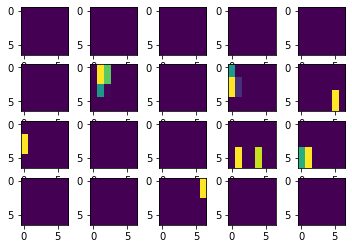

In [39]:
outmap, target = train_roi_ds[5]

print(outmap.shape)
print(target) 

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(outmap[i].cpu().data)

plt.show()

In [50]:
num_epochs = 500
batch_size = 32
learning_rate = 0.001

In [41]:
train_roi_dl = DataLoader(train_roi_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_roi_dl = DataLoader(valid_roi_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

### Setting up features for my ROI Classifier:

In [42]:
class ROI_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(512 * 7 * 7, 128)

        self.reg_layer = nn.Linear(128, 4)  
        self.cls_layer = nn.Linear(128, 2)
         
    def forward(self, x):
        out = x.view(-1, 512 * 7 * 7)
        out = F.relu(self.fc1(out))

        pred_locs  = self.reg_layer(out)
        pred_score = self.cls_layer(out)
        
        return  pred_locs, pred_score

In [51]:
ROI_model = ROI_Classifier().to(device)
optimizer = torch.optim.SGD(ROI_model.parameters(), lr = learning_rate)

In [52]:
epochs_ROI = []
losses_ROI = []

In [54]:
for epoch in range(num_epochs):
    Epoch_LOSS = 0

    for outmap, target in train_roi_dl:
        outmap = outmap.to(device)

        gt_locs  = target[0].to(device).contiguous().view(-1, 4)
        gt_label = target[1].to(device).contiguous().view(-1)

        #forward step
        pred_locs, pred_score = ROI_model(outmap)

        pos  = gt_label > 0
        mask = pos.unsqueeze(1).expand_as(pred_locs)

        pred_locs = pred_locs[mask]
        gt_locs   = gt_locs[mask]

        roi_cls_loss = F.cross_entropy(pred_score, gt_label.long(), ignore_index = -1)
        roi_reg_loss = F.smooth_l1_loss(pred_locs, gt_locs)

        roi_total_loss = 10 * roi_cls_loss + roi_reg_loss
        Epoch_LOSS += roi_total_loss
        
        optimizer.zero_grad(); roi_total_loss.backward()
        optimizer.step()
    
    if (epoch % 20 == 19):
        print(f'Epoch {epoch + 1}/{num_epochs}: train_loss = {Epoch_LOSS}')

    epochs_ROI.append(len(epochs_ROI))
    losses_ROI.append(Epoch_LOSS)

Epoch 20/500: train_loss = 1.4387947899693523
Epoch 40/500: train_loss = 0.7893328275067925
Epoch 60/500: train_loss = 0.5204427230296507
Epoch 80/500: train_loss = 0.382398399176856
Epoch 100/500: train_loss = 0.30042711751568124
Epoch 120/500: train_loss = 0.2453346606870337
Epoch 140/500: train_loss = 0.20571651771738064
Epoch 160/500: train_loss = 0.17662409022247386
Epoch 180/500: train_loss = 0.1543649541631745
Epoch 200/500: train_loss = 0.13639881924523728
Epoch 220/500: train_loss = 0.1224698448306094
Epoch 240/500: train_loss = 0.1106486802485804
Epoch 260/500: train_loss = 0.1010784419974017
Epoch 280/500: train_loss = 0.09274871647405362
Epoch 300/500: train_loss = 0.08583470639383053
Epoch 320/500: train_loss = 0.07967730320273562
Epoch 340/500: train_loss = 0.07394501208943698
Epoch 360/500: train_loss = 0.06988934174155766
Epoch 380/500: train_loss = 0.06531359261932368
Epoch 400/500: train_loss = 0.0614809348359481
Epoch 420/500: train_loss = 0.05818969464208755
Epoch 4

Text(0.5, 1.0, 'Train Loss as a function of epoch-ROI')

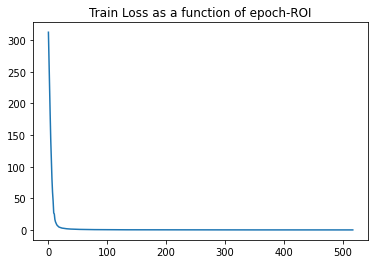

In [55]:
plt.plot(epochs_ROI, losses_ROI)
plt.title("Train Loss as a function of epoch-ROI")

In [56]:
torch.save(ROI_model.state_dict(), 'My_ROI.model')

In [57]:
ROI_model = ROI_Classifier().to(device)
ROI_model.load_state_dict(torch.load('My_ROI.model', map_location = torch.device(device)))

<All keys matched successfully>

Number of rois: 789
Number of predicted boxes: 26


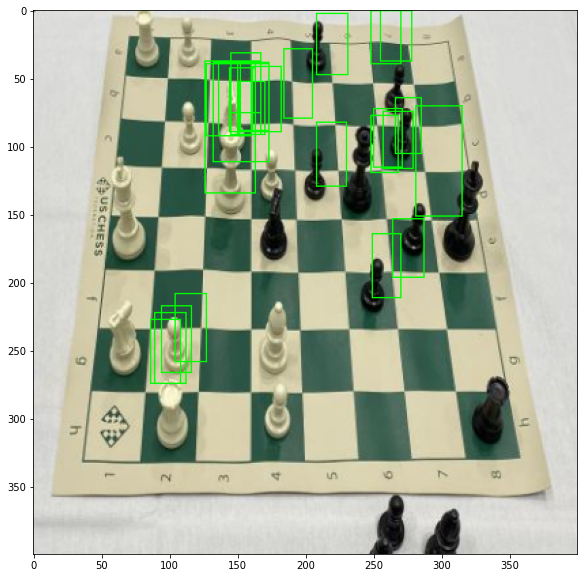

In [69]:
with torch.no_grad():
    img = cv2.imread('/content/test/a3863d0be6002c21b20ac88817b2c56f_jpg.rf.0413d5178136ace55f588df9556c060a.jpg')

    # calculate predicted label and locs
    img_clone = Image_Prep(img)
    img_clone = img_clone.unsqueeze(0).to(device)

    outmap = fe_extractor(img_clone)
    pred_locs, pred_score = RPN_model(outmap)

    pred_locs = pred_locs.permute(0, 2, 3, 1)
    pred_score = pred_score.permute(0, 2, 3, 1)

    rois = NMS_filter(anchor_boxes, pred_locs, pred_score)

    rois_clone = torch.from_numpy(rois).float()
    rois_clone = rois_clone / 8.0 #downsampling ratio
    rois_clone = rois_clone.long()

    fmap = []

    for i in range(rois_clone.shape[0]):
        x1, y1, x2, y2 = rois_clone[i]
        mask = outmap[0][..., x1: x2 + 1, y1: y2 + 1]
        temp = adaptive_max_pool(mask)[0]

        fmap.append(temp)
    
    fmap = torch.cat(fmap)

    pred_locs, pred_score = ROI_model(fmap)
    pred_score = F.softmax(pred_score, dim = 1)
    pred_score_numpy = pred_score.cpu().data.numpy()

    pos_index = np.where(pred_score_numpy[:, 1] > 0.9999)[0]

    pred_locs  = pred_locs[pos_index]
    pred_score = pred_score[pos_index]

    pred_boxes = NMS_filter(rois[pos_index], pred_locs, pred_score)

    # show the bounding box of predicted boxes:
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, dsize = (400, 400), interpolation = cv2.INTER_AREA)

    print(f'Number of rois: {rois.shape[0]}')
    print(f'Number of predicted boxes: {pred_boxes.shape[0]}')

    for i in pos_index:
    #for i in range(pred_boxes.shape[0]):
        x1, y1, x2, y2 = rois[i]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize = (10, 10))
plt.imshow(img)